In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns; sns.set()
sns.set_context('poster'); plt.style.use('fivethirtyeight')

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

from IPython.display import HTML

In [2]:
def percentify_y():
    plt.gca().yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.0f%%'))
    
def percentify_x():
    plt.gca().xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.0f%%'))
    
def output_figure(filename):
    """
    Save the most recently generated chart as a png with the filename passed as an argument
    """
    plt.tight_layout()
    plt.savefig('./charts/coding/' + filename + '.png', dpi=200)

In [14]:
# Downloaded CSV for all complaints with a narrative (i.e., text explanation) from 
# http://www.consumerfinance.gov/complaintdatabase/

df = pd.read_csv('raw/Consumer_Complaints_with_Consumer_Complaint_Narratives.csv', index_col='Complaint ID')
df = df[df['Product'] == 'Credit card'].copy()

df['Relief Indicator'] = [x in {'Closed with non-monetary relief', 'Closed with monetary relief'} for x in df['Company response to consumer']]

df = df.reset_index()[['Relief Indicator', 'Consumer complaint narrative']].copy()
df.columns = ['Relief','Complaint']

In [16]:
#HTML for pasting DF into WordPress

df.head(5)

,Relief,Complaint
0,True,Home Depot habitually credits my account a wee...
1,False,Dear representatives of The Consumer Financial...
2,False,I applied for a credit card with USAA and I wa...
3,False,I believe what happened was a system error. I ...
4,True,I filed a Ch. XXXX Bankruptcy in the XXXX XXXX...


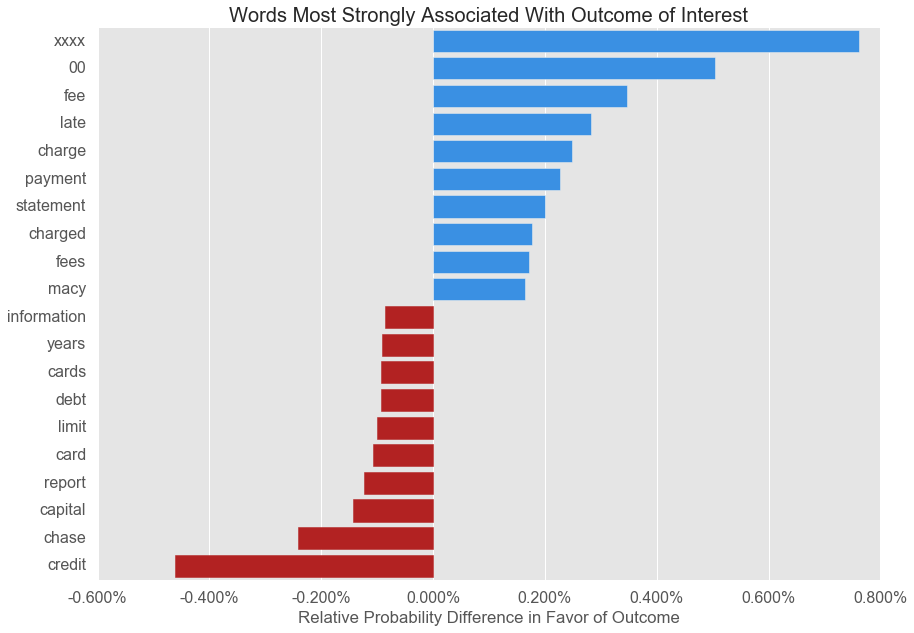

In [5]:
# Words most associated with getting relief

complaints = df['Complaint'].values

vect = CountVectorizer(ngram_range=(1,1), stop_words='english')
X = vect.fit_transform(complaints)
words = vect.get_feature_names()

y = [int(x) for x in df['Relief'].values]

clf = MultinomialNB(alpha=0)
clf.fit(X,y)

likelihood_df = pd.DataFrame(clf.feature_log_prob_.transpose(),columns=['NoRelief', 'Relief'], index=words)

# Undo log of probabilities and take difference to look at relative probability differences
likelihood_df['Percent More Likely to Get Relief'] = likelihood_df.eval('100 * (exp(Relief) - exp(NoRelief))')
top_10 = likelihood_df['Percent More Likely to Get Relief'].sort_values(ascending=False).ix[:10]
bottom_10 = likelihood_df['Percent More Likely to Get Relief'].sort_values().ix[:10].sort_values(ascending=False)
top_and_bottom_10 = pd.concat([top_10,bottom_10])

with plt.style.context('ggplot'):
    sns.barplot(y=top_and_bottom_10.index, x=top_and_bottom_10, color='DodgerBlue')
    plt.ylabel('')
    plt.xlabel('Relative Probability Difference in Favor of Outcome')
    plt.title('Words Most Strongly Associated With Outcome of Interest')
    plt.gca().xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.3f%%'))
    for bar in plt.gca().get_children()[10:20]:
        bar.set_color('FireBrick')
    output_figure('top_bottom_ten_words')

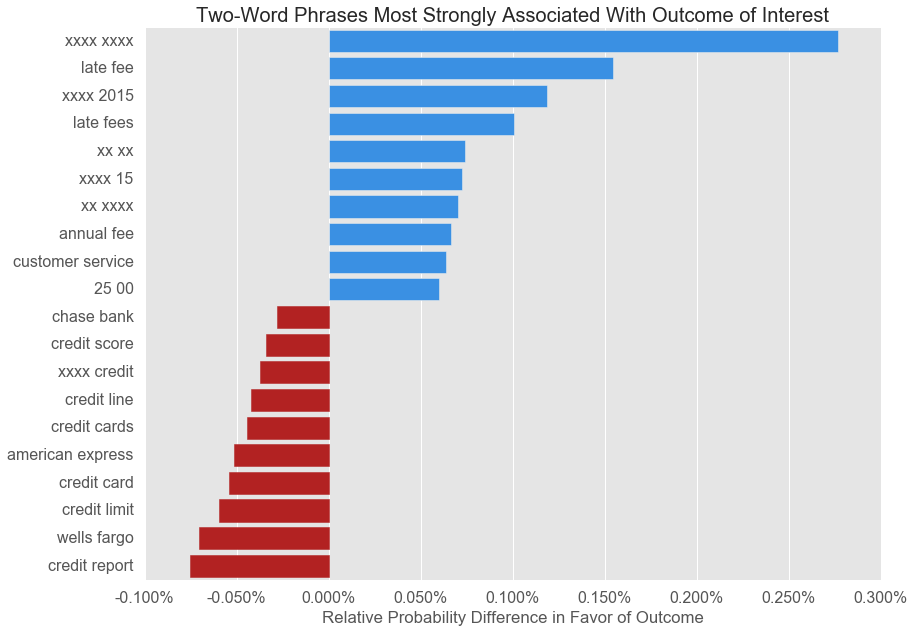

In [6]:
# 2-grams most associated with getting relief


vect = CountVectorizer(ngram_range=(2,2), stop_words='english')
X = vect.fit_transform(complaints)
words = vect.get_feature_names()

y = [int(x) for x in df['Relief'].values]

clf = MultinomialNB(alpha=0)
clf.fit(X,y)

likelihood_df = pd.DataFrame(clf.feature_log_prob_.transpose(),columns=['NoRelief', 'Relief'], index=words)

# Undo log of probabilities and take difference to look at relative probability differences
likelihood_df['Percent More Likely to Get Relief'] = likelihood_df.eval('100 * (exp(Relief) - exp(NoRelief))')
top_10 = likelihood_df['Percent More Likely to Get Relief'].sort_values(ascending=False).ix[:10]
bottom_10 = likelihood_df['Percent More Likely to Get Relief'].sort_values().ix[:10].sort_values(ascending=False)
top_and_bottom_10 = pd.concat([top_10,bottom_10])

with plt.style.context('ggplot'):
    sns.barplot(y=top_and_bottom_10.index, x=top_and_bottom_10, color='DodgerBlue')
    plt.ylabel('')
    plt.xlabel('Relative Probability Difference in Favor of Outcome')
    plt.title('Two-Word Phrases Most Strongly Associated With Outcome of Interest')
    plt.gca().xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.3f%%'))
    for bar in plt.gca().get_children()[10:20]:
        bar.set_color('FireBrick')
    output_figure('top_bottom_ten_2_grams')

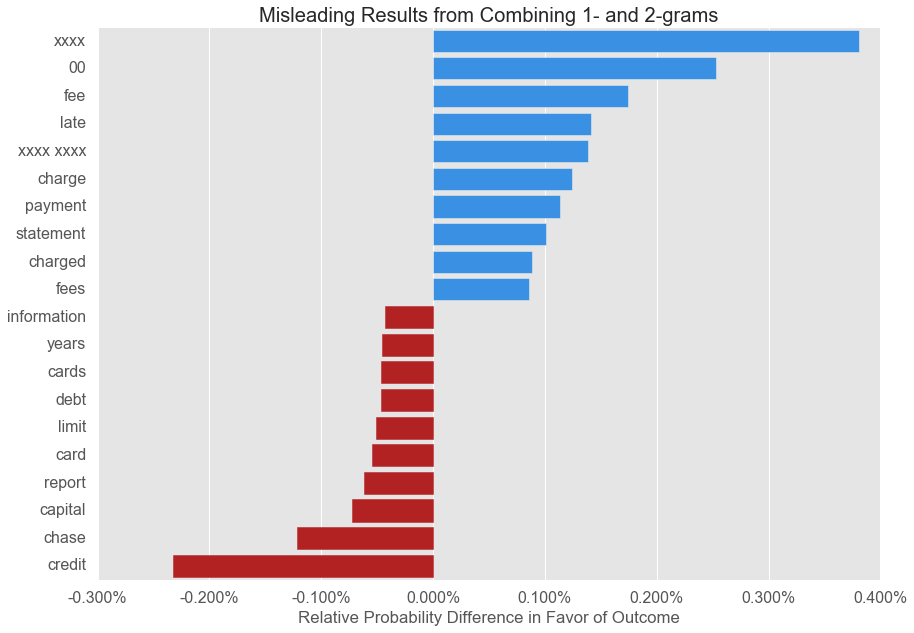

In [7]:
# Why not to use this approach for n-grams of different lengths at the same time

vect = CountVectorizer(ngram_range=(1,2), stop_words='english')
X = vect.fit_transform(complaints)
words = vect.get_feature_names()

y = [int(x) for x in df['Relief'].values]

clf = MultinomialNB(alpha=0)
clf.fit(X,y)

likelihood_df = pd.DataFrame(clf.feature_log_prob_.transpose(),columns=['NoRelief', 'Relief'], index=words)

# Undo log of probabilities and take difference to look at relative probability differences
likelihood_df['Percent More Likely to Get Relief'] = likelihood_df.eval('100 * (exp(Relief) - exp(NoRelief))')
top_10 = likelihood_df['Percent More Likely to Get Relief'].sort_values(ascending=False).ix[:10]
bottom_10 = likelihood_df['Percent More Likely to Get Relief'].sort_values().ix[:10].sort_values(ascending=False)
top_and_bottom_10 = pd.concat([top_10,bottom_10])

with plt.style.context('ggplot'):
    sns.barplot(y=top_and_bottom_10.index, x=top_and_bottom_10, color='DodgerBlue')
    plt.ylabel('')
    plt.xlabel('Relative Probability Difference in Favor of Outcome')
    plt.title('Misleading Results from Combining 1- and 2-grams')
    plt.gca().xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.3f%%'))
    for bar in plt.gca().get_children()[10:20]:
        bar.set_color('FireBrick')
    output_figure('top_bottom_ten_words')

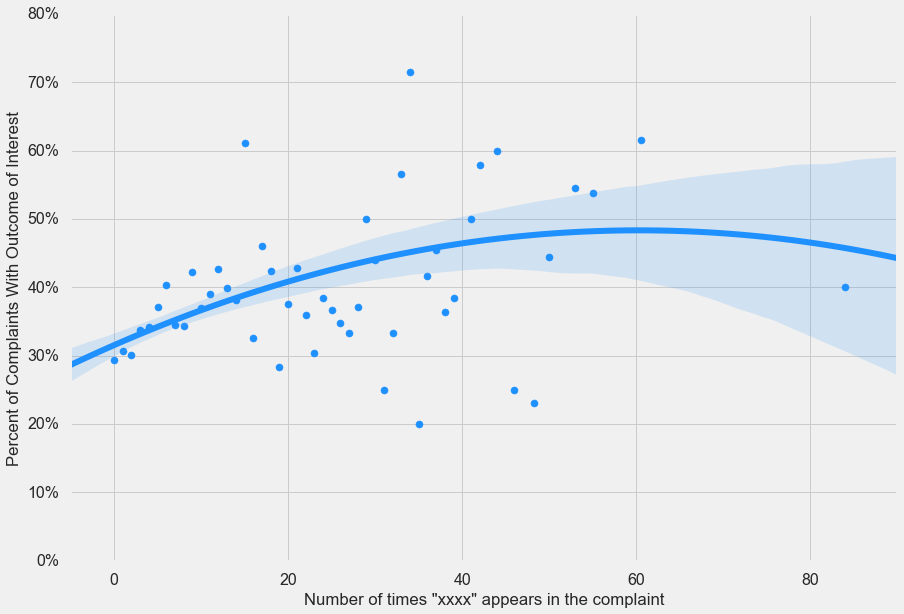

In [10]:
# That negative value for xxxx above is definitely misleading...

df['XXXX Count'] = [x.lower().count('xxxx') for x in complaints]

sns.regplot(x=df['XXXX Count'], y=100*df['Relief'], x_bins=500, x_ci=None, order=2, color='DodgerBlue')
plt.xlim((-5,90))
percentify_y()
plt.ylabel('Percent of Complaints With Outcome of Interest')
plt.xlabel('Number of times "xxxx" appears in the complaint')
output_figure('xxxx_versus_perc_relief')